In [1]:
import os
import time
import random
import numpy as np
import cv2
import torch
from tqdm import tqdm
""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
def creat_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [2]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)
        
    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0   ##(512,512,3)
        image = np.transpose(image,(2, 0, 1))   ##(3,512,512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        
        """ Reading masks """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ##(512,512,3)
        mask = np.expand_dims(mask, axis=0)   ##(1,512,512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        
        
        return image, mask
    
    def __len__(self):
        return self.n_samples
    


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


In [4]:
'''train'''
import os
import time
from glob import glob

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

"""Choose device"""
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print("use", device ,"now!")



def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    
    model.eval()
    with torch.no_grad():     ###不需要計算梯度，也不會進行反向傳播
        for x,y in tqdm(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()
        epoch_loss=epoch_loss/len(loader)
    scheduler.step(epoch_loss)
    return epoch_loss



use cuda now!


In [5]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in tqdm(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [13]:
from U_Net_ResNet import U_Net_ResNet50
save_name = 'U_Net_ResNet50'

In [7]:
# from U_Net import U_Net
from U_Net_ResNet import U_Net_ResNet50
# from U_Net_ResNet_ASPP import U_Net_ResNet50_ASPP   

save_name = 'U_Net_ResNet50_ASPP_2'

loss_plot = []
loss_val_plot = []
""" Seeding """ 
seeding(42)

""" Directories """ 
creat_dir("files")
data_path = './eyedata'
""" Load dataset """ 
train_x = sorted(glob(os.path.join(data_path,'train','image','*'))) 
train_y = sorted(glob(os.path.join(data_path,'train','mask','*')))

valid_x = sorted(glob(os.path.join(data_path,'test','image','*')))
valid_y = sorted(glob(os.path.join(data_path,'test','mask','*')))

data_str = f"Dataset Size:\nTrain: {len(train_x)}-Valid: {len(valid_x)}\n" 
print(data_str)

""" Hyperparameters """
H = 512 
W = 512 
size = (H,W) 
batch_size = 1
num_epochs = 200
patient = 30
stale = 0
lr = 6e-4
checkpoint_path = f"./{save_name}_best.pth"

""" Dataset and Loader """ 
train_dataset = DriveDataset(train_x, train_y) 
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader( 
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    #num_workers=0 
) 
valid_loader = DataLoader( 
    dataset=valid_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    #num_workers=0 
)

model = U_Net_ResNet50_ASPP(out_c = 1) 
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)#, weight_decay = 3e-4)
# optimizer = torch.optim.SGD(model.parameters(),lr=lr, momentum = 0.7, weight_decay = 3e-4)
# optimizer = torch.optim.RMSprop(model.parameters(),lr=lr,momentum=0.45,weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5, verbose=True) ###若指標沒有變更好則降低學習率 
loss_fn = DiceBCELoss()

"""Training the model""" 
best_valid_loss = float("inf")

for epoch in range(num_epochs): 
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)
    """ Saving the model """
    if valid_loss< best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint:{checkpoint_path}"
        print(data_str)
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)
        stale = 0
    else:
        stale += 1
        if stale >= patient:
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            data_str = f'Epoch: {epoch+1:02} | Epoch Time:{epoch_mins}m {epoch_secs}s\n'
            data_str += f'\tTrain Loss: {train_loss:.3f}\n'
            data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
            print(data_str)
            print('No improve!!')
            break
    loss_plot.append(train_loss)
    loss_val_plot.append(valid_loss)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    data_str = f'Epoch: {epoch+1:02} | Epoch Time:{epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

Dataset Size:
Train: 80-Valid: 20



100%|██████████| 20/20 [00:00<00:00, 21.62it/s]


Valid loss improved from inf to 0.9941. Saving checkpoint:./U_Net_ResNet50_ASPP_2_best.pth
Epoch: 01 | Epoch Time:0m 12s
	Train Loss: 0.919
	 Val. Loss: 0.994



100%|██████████| 20/20 [00:00<00:00, 21.65it/s]


Valid loss improved from 0.9941 to 0.5673. Saving checkpoint:./U_Net_ResNet50_ASPP_2_best.pth
Epoch: 02 | Epoch Time:0m 12s
	Train Loss: 0.575
	 Val. Loss: 0.567



100%|██████████| 20/20 [00:00<00:00, 21.61it/s]


Valid loss improved from 0.5673 to 0.5117. Saving checkpoint:./U_Net_ResNet50_ASPP_2_best.pth
Epoch: 03 | Epoch Time:0m 12s
	Train Loss: 0.447
	 Val. Loss: 0.512



100%|██████████| 20/20 [00:00<00:00, 21.66it/s]


Valid loss improved from 0.5117 to 0.4235. Saving checkpoint:./U_Net_ResNet50_ASPP_2_best.pth
Epoch: 04 | Epoch Time:0m 12s
	Train Loss: 0.393
	 Val. Loss: 0.424



100%|██████████| 20/20 [00:00<00:00, 21.76it/s]


Epoch: 05 | Epoch Time:0m 12s
	Train Loss: 0.378
	 Val. Loss: 0.463



100%|██████████| 20/20 [00:00<00:00, 21.73it/s]


Valid loss improved from 0.4235 to 0.3926. Saving checkpoint:./U_Net_ResNet50_ASPP_2_best.pth
Epoch: 06 | Epoch Time:0m 12s
	Train Loss: 0.360
	 Val. Loss: 0.393



100%|██████████| 20/20 [00:00<00:00, 21.73it/s]


Epoch: 07 | Epoch Time:0m 12s
	Train Loss: 0.349
	 Val. Loss: 0.394



100%|██████████| 20/20 [00:00<00:00, 21.73it/s]


Epoch: 08 | Epoch Time:0m 12s
	Train Loss: 0.338
	 Val. Loss: 0.407



100%|██████████| 20/20 [00:00<00:00, 21.74it/s]


Epoch: 09 | Epoch Time:0m 12s
	Train Loss: 0.335
	 Val. Loss: 0.453



100%|██████████| 20/20 [00:00<00:00, 21.65it/s]


Valid loss improved from 0.3926 to 0.3761. Saving checkpoint:./U_Net_ResNet50_ASPP_2_best.pth
Epoch: 10 | Epoch Time:0m 12s
	Train Loss: 0.327
	 Val. Loss: 0.376



100%|██████████| 20/20 [00:00<00:00, 21.57it/s]


Epoch: 11 | Epoch Time:0m 12s
	Train Loss: 0.320
	 Val. Loss: 0.400



100%|██████████| 20/20 [00:00<00:00, 21.72it/s]


Epoch: 12 | Epoch Time:0m 12s
	Train Loss: 0.310
	 Val. Loss: 0.387



100%|██████████| 20/20 [00:00<00:00, 21.72it/s]


Valid loss improved from 0.3761 to 0.3605. Saving checkpoint:./U_Net_ResNet50_ASPP_2_best.pth
Epoch: 13 | Epoch Time:0m 12s
	Train Loss: 0.309
	 Val. Loss: 0.360



100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


Epoch: 14 | Epoch Time:0m 12s
	Train Loss: 0.305
	 Val. Loss: 0.420



100%|██████████| 20/20 [00:00<00:00, 21.75it/s]


Epoch: 15 | Epoch Time:0m 12s
	Train Loss: 0.297
	 Val. Loss: 0.377



100%|██████████| 20/20 [00:00<00:00, 21.65it/s]


Epoch: 16 | Epoch Time:0m 12s
	Train Loss: 0.291
	 Val. Loss: 0.404



100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


Epoch: 17 | Epoch Time:0m 12s
	Train Loss: 0.289
	 Val. Loss: 0.419



100%|██████████| 20/20 [00:00<00:00, 21.72it/s]


Epoch: 18 | Epoch Time:0m 12s
	Train Loss: 0.286
	 Val. Loss: 0.429



100%|██████████| 20/20 [00:00<00:00, 21.74it/s]


Epoch 00019: reducing learning rate of group 0 to 6.0000e-05.
Epoch: 19 | Epoch Time:0m 12s
	Train Loss: 0.280
	 Val. Loss: 0.416



100%|██████████| 20/20 [00:00<00:00, 21.75it/s]


Epoch: 20 | Epoch Time:0m 12s
	Train Loss: 0.267
	 Val. Loss: 0.408



100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


Epoch: 21 | Epoch Time:0m 12s
	Train Loss: 0.257
	 Val. Loss: 0.390



100%|██████████| 20/20 [00:00<00:00, 21.71it/s]


Epoch: 22 | Epoch Time:0m 12s
	Train Loss: 0.252
	 Val. Loss: 0.394



100%|██████████| 20/20 [00:00<00:00, 21.67it/s]


Epoch: 23 | Epoch Time:0m 12s
	Train Loss: 0.248
	 Val. Loss: 0.408



100%|██████████| 20/20 [00:00<00:00, 21.73it/s]


Epoch: 24 | Epoch Time:0m 12s
	Train Loss: 0.245
	 Val. Loss: 0.423



100%|██████████| 20/20 [00:00<00:00, 21.75it/s]


Epoch 00025: reducing learning rate of group 0 to 6.0000e-06.
Epoch: 25 | Epoch Time:0m 12s
	Train Loss: 0.241
	 Val. Loss: 0.492



100%|██████████| 20/20 [00:00<00:00, 21.75it/s]


Epoch: 26 | Epoch Time:0m 12s
	Train Loss: 0.238
	 Val. Loss: 0.427



100%|██████████| 20/20 [00:00<00:00, 21.61it/s]


Epoch: 27 | Epoch Time:0m 12s
	Train Loss: 0.237
	 Val. Loss: 0.442



100%|██████████| 20/20 [00:00<00:00, 21.73it/s]


Epoch: 28 | Epoch Time:0m 12s
	Train Loss: 0.237
	 Val. Loss: 0.443



100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


Epoch: 29 | Epoch Time:0m 12s
	Train Loss: 0.236
	 Val. Loss: 0.400



100%|██████████| 20/20 [00:00<00:00, 21.23it/s]


Epoch: 30 | Epoch Time:0m 12s
	Train Loss: 0.236
	 Val. Loss: 0.417



100%|██████████| 20/20 [00:00<00:00, 21.67it/s]


Epoch 00031: reducing learning rate of group 0 to 6.0000e-07.
Epoch: 31 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.411



100%|██████████| 20/20 [00:00<00:00, 21.72it/s]


Epoch: 32 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.410



100%|██████████| 20/20 [00:00<00:00, 21.71it/s]


Epoch: 33 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.469



100%|██████████| 20/20 [00:00<00:00, 21.72it/s]


Epoch: 34 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.417



100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


Epoch: 35 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.405



100%|██████████| 20/20 [00:00<00:00, 21.64it/s]


Epoch: 36 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.430



100%|██████████| 20/20 [00:00<00:00, 21.68it/s]


Epoch 00037: reducing learning rate of group 0 to 6.0000e-08.
Epoch: 37 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.431



100%|██████████| 20/20 [00:00<00:00, 21.63it/s]


Epoch: 38 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.407



100%|██████████| 20/20 [00:00<00:00, 21.76it/s]


Epoch: 39 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.403



100%|██████████| 20/20 [00:00<00:00, 21.73it/s]


Epoch: 40 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.437



100%|██████████| 20/20 [00:00<00:00, 21.69it/s]


Epoch: 41 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.417



100%|██████████| 20/20 [00:00<00:00, 21.72it/s]


Epoch: 42 | Epoch Time:0m 12s
	Train Loss: 0.235
	 Val. Loss: 0.393



100%|██████████| 20/20 [00:00<00:00, 21.73it/s]

Epoch 00043: reducing learning rate of group 0 to 6.0000e-09.
Epoch: 43 | Epoch Time:0m 0s
	Train Loss: 0.235
	 Val. Loss: 0.481

No improve!!


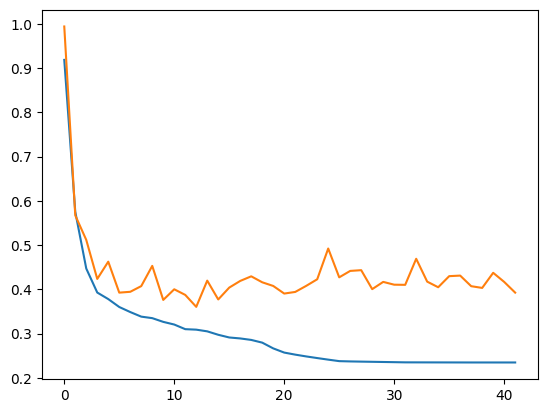

In [11]:
import matplotlib.pyplot as plt
plt.plot(loss_plot)
plt.plot(loss_val_plot)
plt.savefig(f'./{save_name} loss.png',dpi=600)
plt.show()

In [14]:
""" Test """
import os,time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm

import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()     ###將資料從tensor轉成numpy的屬性並將資料放入cpu
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)
    
    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)
    
    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)
    
    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)     ###(512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)     ###(512,512,3)
    return mask
path = os.path.join(data_path)
    
"""Choose device"""
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print("use", device ,"now!")

""" seeding """
seeding(42)

""" Load dataset """
test_x = sorted(glob(os.path.join(path,'test','image','*')))
test_y = sorted(glob(os.path.join(path,'test','mask','*')))

""" Hyperparameters """
H = 512
W = 512
size = (W,H)
checkpoint_path = f"./{save_name}_best.pth"

""" Load the checkpoint """

model = U_Net_ResNet50(1)
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

matrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
time_taken = []
index = 0
data_path="./eyedata/"
for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    """ Extract the name """
    name = x.split("/")[-1].split("\\")[-1].split(".")[0]
    
    """ Reading image """
    image = cv2.imread(x,cv2.IMREAD_COLOR)     ###(512,512,3)
    x = np.transpose(image,(2, 0, 1))     ###(3,512,512)
    x = x/255.0
    x = np.expand_dims(x, axis=0)     ###(1,3,512,512)
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.to(device)
    """ Reading mask """
    mask = cv2.imread(y,cv2.IMREAD_GRAYSCALE)     ###(512,512)
    y = np.expand_dims(mask, axis=0)     ###(1,512,512)
    y = y/255.0
    y = np.expand_dims(y, axis=0)     ###(1,1,512,512)
    y = y.astype(np.float32)
    y = torch.from_numpy(y)
    y = y.to(device)
    
    with torch.no_grad():
        """ Prediction and calculating FPS """
        start_time = time.time()
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)
        total_time = time.time()-start_time
        time_taken.append(total_time)
        
        score = calculate_metrics(y,pred_y)
        matrics_score = list(map(add, matrics_score, score))
        pred_y = pred_y[0].cpu().numpy()     ###(1,512,512)
        pred_y = np.squeeze(pred_y, axis=0)  ###(512,512)
        pred_y = pred_y>0.5
        pred_y = np.array(pred_y, dtype=np.uint8)
        
    """ Saving masks """
    ori_mask = mask_parse(mask)
    pred_y = mask_parse(pred_y)
    line = np.ones((size[1], 10, 3)) * 128
    
    
    cat_images = np.concatenate(
        [image, line, ori_mask, line, pred_y * 255], axis=1
    )
    #print(cat_images.shape)
    """ Folders """
    tmp_result_name = f"{name}_{index}.png"
    creat_dir(os.path.join('./',"new_data",save_name))
    result_name = os.path.join('./',"new_data", save_name, tmp_result_name)
    
    cv2.imwrite(result_name, cat_images)
    index +=1
    
jaccard = matrics_score[0]/len(test_x)
f1 = matrics_score[1]/len(test_x)
recall = matrics_score[2]/len(test_x)
precision = matrics_score[3]/len(test_x)
acc = matrics_score[4]/len(test_x)
print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall:{recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

fps = 1/np.mean(time_taken)
print("FPS: ", fps)

use cuda now!


100%|██████████| 20/20 [00:03<00:00,  5.39it/s]

Jaccard: 0.6620 - F1: 0.7956 - Recall:0.7728 - Precision: 0.8290 - Acc: 0.9657
FPS:  204.79250027464815
